In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as st
# import pymc3 as pm
import seaborn as sns
import wtascripts.wta_helpers as wta_helpers

# enables inline plots, without it plots don't show up in the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# %config InlineBackend.figure_format = 'png'
# mpl.rcParams['figure.dpi']= 300

# import warnings
# warnings.simplefilter('ignore')

In [2]:
# Sklearn specific imports
from sklearn.preprocessing import StandardScaler, LabelBinarizer, MultiLabelBinarizer, PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)
plt.rcParams['figure.figsize'] = (8,5)

## Helper Functions

In [4]:
def residual_plot(y_pred, y_train):
    res = y_train - y_pred
    plt.scatter(y_pred, res, s=3)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    return plt.show();

### Preprocessing

In [5]:
# Load then clean dataset
df = wta_helpers.load_raw_df()
df = wta_helpers.clean_raw_df(df)

In [102]:
# Create 

# df = df[df.countreports > 0]
# df['log_countreports'] = np.log(df['countreports'])
# df['log_votes'] = np.log(df['votes'])

In [23]:
onehot_feats = ['Wildflowers/Meadows', 'Ridges/passes',
'Wildlife','Waterfalls','Old growth','Summits','Good for kids','Dogs allowed on leash',
'Fall foliage','Lakes','Rivers','Coast','Mountain views','Established campsites',]
# Not used: lat, long, subregion, lengthtype


#cont_feats = ['votes', 'countreports', 'length', 'gain', 'hpoint']

# use below if doing log of countreports and votes
# cont_feats = ['votes', 'countreports', 'length', 'gain', 'hpoint', 'log_countreports', 'log_votes']


cont_feats = ['rating', 'length', 'gain', 'hpoint']


# cont_feats = ['votes', 'length', 'gain', 'hpoint']
# cont_feats = ['length', 'gain', 'hpoint']

oh_cols = df[onehot_feats]

#Standardize the non one-hot encoding variables into XS
s = StandardScaler()
XS = s.fit_transform(df[cont_feats])
#print(oh_cols)
# combine with the one hot encoding variables

# multilabelbinarizer for 'fees' column
mlb = MultiLabelBinarizer()
fees_processed = mlb.fit_transform(df['fee'].str.replace(", ",",").str.split(","))

# labelbinarizer for 'region' column
lb = LabelBinarizer()
region_processed = lb.fit_transform(df['region'])

X = np.concatenate([XS, oh_cols, fees_processed, region_processed], axis=1) ## All features
# X = np.concatenate([oh_cols, fees_processed, region_processed], axis=1) ## Remove continuous features
# X = np.concatenate([XS], axis=1) ## Only continuous features

y = df['votes'] # SEE BELOW - I NOW MADE y and X OFF A PANDAS DATAFRAME

# This code makes a DF of my transformed variables. There is some weird stuff in there with neg lengths...
y2 = y[:,np.newaxis]
XSpecial = np.concatenate([X, y2], axis=1)

df_model = pd.DataFrame(XSpecial, columns= (cont_feats + onehot_feats + list(mlb.classes_) + list(lb.classes_) + ['votes']))

y = df_model['votes']
X = df_model.drop('votes',axis=1)

## Tips from Chad on what I can do now:
* Plot whatever feats I want to explore vs residuals
* Look for patterns in data
* If I am missing data in a certain area of my predicted vs actual plots, then take subset and look there
* plot sum /log / function of the categorical features, vs residuals.

##### Once I find a pattern and want to Feat Eng., then add a new column to my X data array.

In [ ]:
# Who is our audience for Project 2? Recruiters? classmates?
### How do you recommend showing model? Need coefficients. Just "say" how well it did on a few?

### Should I graph out MSE test vs train to help me decide on polynomial degrees? I already know 2 is better
### than 3 or 1

# Graphs probably look good in presentation.

# Test Train Split

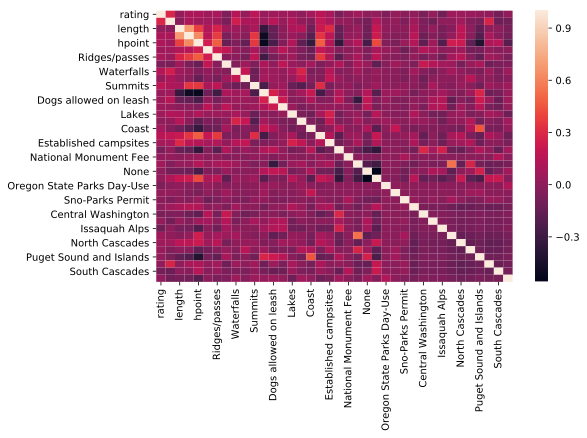

In [12]:
sns.heatmap(X.corr());

In [14]:
X.shape
y.shape

(1211,)

In [275]:
#pprint.pprint(coefs)

In [290]:
# New training based on excluding variables that a LassoCV zeroed out
X_lassoed = X.drop(columns=['length','gain','hpoint','Dogs allowed on leash', 'Established campsites', 'National Monument Fee',
      'None','Refuge Entrance Pass', 'Central Washington','Eastern Washington', 'North Cascades',
      'Snoqualmie Region', 'Southwest Washington'])

# second Lasso to weed out more

X_again = X_lassoed.drop(columns=['Central Cascades', 'Northwest Forest Pass','Rivers'])

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [295]:
# Reduced features due to lasso
X_train, X_test, y_train, y_test = train_test_split(X_lassoed, y)

In [291]:
# Reduced features FOR THE 2ND TIME due to lasso
X_train, X_test, y_train, y_test = train_test_split(X_again, y)

### Test Suite

In [25]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print("LinReg - Poly 1")
print("Train R^2:", lr.score(X_train, y_train))
print("Train MSE:", metrics.mean_squared_error(y_train, lr.predict(X_train)))
print("")

poly_lr = make_pipeline(PolynomialFeatures(2), LinearRegression())
# cross_validate(poly_lr, X_train, y=y_train)
poly_lr.fit(X_train, y_train)
print("LinReg - Poly 2")
print("Train R^2:", poly_lr.score(X_train, y_train))
print("Train MSE:", metrics.mean_squared_error(y_train, poly_lr.predict(X_train)))
print("")

lasso = LassoCV(cv=5)
lasso.fit(X_train, y_train)
print("LassoCV - Poly 1")
print("Train R^2:", lasso.score(X_train, y_train))
print("Train MSE:", metrics.mean_squared_error(y_train, lasso.predict(X_train)))
print("")

# poly_lasso = make_pipeline(PolynomialFeatures(2), LassoCV(cv=5))
# poly_lasso.fit(X_train, y_train)
# print("LassoCV - Poly 2")
# print("Train R^2:", poly_lasso.score(X_train, y_train))
# print("")

ridge = RidgeCV(cv=5)
ridge.fit(X_train, y_train)
print("RR - Poly 1")
print("Train R^2:", ridge.score(X_train, y_train))
print("Train MSE:", metrics.mean_squared_error(y_train, ridge.predict(X_train)))
print("")

poly_ridge = make_pipeline(PolynomialFeatures(2), RidgeCV(cv=5))
poly_ridge.fit(X_train, y_train)
print("RR - Poly 2")
print("Train R^2:", poly_ridge.score(X_train, y_train))
print("Train MSE:", metrics.mean_squared_error(y_train, poly_ridge.predict(X_train)))


LinReg - Poly 1
Train R^2: 0.21973034277634307
Train MSE: 485.74952046986704

LinReg - Poly 2
Train R^2: 0.6941738846962306
Train MSE: 190.3891654387201

LassoCV - Poly 1
Train R^2: 0.21494637867620559
Train MSE: 488.72773222790903

RR - Poly 1
Train R^2: 0.2162477469554731
Train MSE: 487.9175776720364



/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RR - Poly 2
Train R^2: 0.6061455209311555
Train MSE: 245.19039356641542


/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Linear Regression

In [115]:
lr = LinearRegression()
lr.fit(X_train, y_train)

print("intercept:",lr.intercept_)
# print("coefficients,",lr.coef_)

y_pred_tr = lr.predict(X_train)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_tr)))
print("Train MSE:", metrics.mean_squared_error(y_train, y_pred_tr))
print("Train R^2:", lr.score(X_train, y_train))
print("")

##### Save these for final model evaluation!
# print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# print("Test MSE:", metrics.mean_squared_error(y_test, y_pred))
# print('Test R^2: ', est.score(X_test, y_test))z

print("")

#coefs_list = cont_feats + onehot_feats + list(mlb.classes_) + list(lb.classes_) ## Everything
# newlist = onehot_feats + list(mlb.classes_) + list(lb.classes_) ## remove continuous features
# newlist = cont_feats ## only continuous features
#pprint.pprint(sorted(zip(coefs_list, np.round(lr.coef_,3)), key=lambda x: x[1], reverse=True))

intercept: 3.7289478958928592
Train RMSE: 0.5848968484284872
Train MSE: 0.3421043233015768
Train R^2: 0.25435682938956783




In [282]:
"""Polynomial with LinearRegression"""

poly_lr = make_pipeline(PolynomialFeatures(2), LinearRegression())
poly_lr.fit(X_train, y_train)

y_pred_tr = poly_lr.predict(X_train)


print("Train RMSE:", np.sqrt(mean_squared_error(y_train, poly_lr.predict(X_train))))
print("Train MSE:", metrics.mean_squared_error(y_train, poly_lr.predict(X_train)))
print("Train R^2:", poly_lr.score(X_train, y_train))
print("")


y_pred_test = poly_lr.predict(X_test)

##### Save these for final model evaluation!
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("Test MSE:", mean_squared_error(y_test, y_pred_test))
print('Test R^2: ', poly_lr.score(X_test, y_test))

print("")

#coefs_list = cont_feats + onehot_feats + list(mlb.classes_) + list(lb.classes_) ## Everything
# newlist = onehot_feats + list(mlb.classes_) + list(lb.classes_) ## remove continuous features
# newlist = cont_feats ## only continuous features
#pprint.pprint(sorted(zip(coefs_list, np.round(poly_lr.coef_,3)), key=lambda x: x[1], reverse=True))

Train RMSE: 0.4907538593684685
Train MSE: 0.24083935048504654
Train R^2: 0.47544942090890224

Test RMSE: 2158760603.289277
Test MSE: 4.660247342313883e+18
Test R^2:  -1.120213144072864e+19



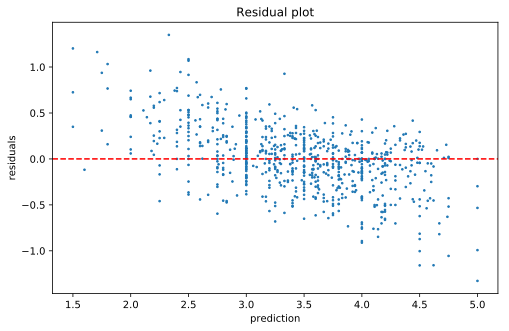

In [13]:
# plot of poly_lr
residual_plot(y_train, poly_lr.predict(X_train))

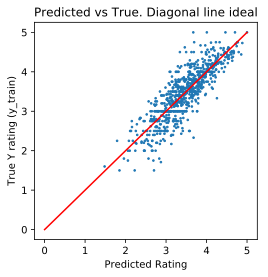

In [15]:
plt.figure(figsize=(4,4))
plt.scatter(poly_lr.predict(X_train), y_train, s=3)
plt.xlabel("Predicted Rating")
plt.ylabel("True Y rating (y_train)")
plt.title("Predicted vs True. Diagonal line ideal")
plt.plot(range(6), c='r');

# Lasso

In [16]:
#alphas = [1e-14,1e-10,1e-6,1e-3,1e-2,1e-1,1,10,100]
lasso = LassoCV(cv=5)
lasso.fit(X_train, y_train)
print("intercept:",lasso.intercept_)
# print("coefficients,",lasso.coef_)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, lasso.predict(X_train))))
print("Train MSE:", metrics.mean_squared_error(y_train, lasso.predict(X_train)))
print("Train R^2:", lasso.score(X_train, y_train))
print("")

##### Save these for final model evaluation!
# print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# print("Test MSE:", metrics.mean_squared_error(y_test, y_pred))
# print('Test R^2: ', est.score(X_test, y_test))

print("")

#coefs_list = cont_feats + onehot_feats + list(mlb.classes_) + list(lb.classes_) ## Everything
# newlist = onehot_feats + list(mlb.classes_) + list(lb.classes_) ## remove continuous features
# newlist = cont_feats ## only continuous features
#pprint.pprint(sorted(zip(coefs_list, np.round(lasso.coef_,3)), key=lambda x: x[1], reverse=True))

intercept: 3.2148247177768745
Train RMSE: 0.5883878227099554
Train MSE: 0.3462002299133619
Train R^2: 0.2192402841458504




In [26]:
"""Polynomial with LassoCV"""

alphas = [1e-14,1e-10,1e-6,1e-3,1e-2,1e-1,1,100]
poly_lasso = make_pipeline(PolynomialFeatures(2, interaction_only=True), LassoCV(cv=3, alphas=alphas))
poly_lasso.fit(X_train, y_train)
#print("intercept:",poly_lasso.intercept_)
# print("coefficients,",poly_lasso.coef_)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, poly_lasso.predict(X_train))))
print("Train MSE:", metrics.mean_squared_error(y_train, poly_lasso.predict(X_train)))
print("Train R^2:", poly_lasso.score(X_train, y_train))
print("")

##### Save these for final model evaluation!
print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, poly_lasso.predict(X_test))))
print("Test MSE:", metrics.mean_squared_error(y_test, poly_lasso.predict(X_test)))
print('Test R^2: ', poly_lasso.score(X_test, y_test))

print("")

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

Train RMSE: 17.548179573807037
Train MSE: 307.9386063545785
Train R^2: 0.5053517487906141

Test RMSE: 17.778706989331408
Test MSE: 316.0824222125014
Test R^2:  -0.03188501504728203



In [20]:
simple_lasso= LassoCV(cv=3)
simple_lasso.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=3, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [22]:
coefs_list = X.columns
# newlist = onehot_feats + list(mlb.classes_) + list(lb.classes_) ## remove continuous features
# newlist = cont_feats ## only continuous features
import pprint
coefs = sorted(zip(coefs_list, np.round(simple_lasso.coef_,3)), key=lambda x: x[1], reverse=True)
pprint.pprint(coefs)

[('countreports', 22.022),
 ('South Cascades', 1.065),
 ('Wildlife', 0.406),
 ('Lakes', 0.05),
 ('length', 0.0),
 ('Wildflowers/Meadows', 0.0),
 ('Ridges/passes', 0.0),
 ('Waterfalls', 0.0),
 ('Summits', 0.0),
 ('Good for kids', 0.0),
 ('Dogs allowed on leash', -0.0),
 ('Rivers', -0.0),
 ('Coast', 0.0),
 ('Mountain views', -0.0),
 ('Discover Pass', -0.0),
 ('National Monument Fee', -0.0),
 ('National Park Pass', 0.0),
 ('None', 0.0),
 ('Northwest Forest Pass', -0.0),
 ('Oregon State Parks Day-Use', -0.0),
 ('Refuge Entrance Pass', 0.0),
 ('Sno-Parks Permit', -0.0),
 ('Central Cascades', -0.0),
 ('Central Washington', 0.0),
 ('Eastern Washington', 0.0),
 ('Issaquah Alps', -0.0),
 ('Mount Rainier Area', -0.0),
 ('North Cascades', 0.0),
 ('Olympic Peninsula', 0.0),
 ('Puget Sound and Islands', 0.0),
 ('Southwest Washington', 0.0),
 ('rating', -0.317),
 ('hpoint', -0.495),
 ('gain', -0.597),
 ('Old growth', -0.755),
 ('Established campsites', -0.921),
 ('Fall foliage', -1.115),
 ('Snoqualm

In [267]:
coefs

[('Summits', 0.206),
 ('countreports', 0.18),
 ('Puget Sound and Islands', 0.18),
 ('Waterfalls', 0.141),
 ('Good for kids', 0.137),
 ('Mount Rainier Area', 0.136),
 ('Mountain views', 0.112),
 ('Ridges/passes', 0.09),
 ('Olympic Peninsula', 0.09),
 ('Coast', 0.085),
 ('Fall foliage', 0.056),
 ('Lakes', 0.036),
 ('Sno-Parks Permit', 0.034),
 ('National Park Pass', 0.025),
 ('Wildflowers/Meadows', 0.024),
 ('length', -0.0),
 ('gain', 0.0),
 ('hpoint', 0.0),
 ('Dogs allowed on leash', -0.0),
 ('Established campsites', 0.0),
 ('National Monument Fee', 0.0),
 ('None', -0.0),
 ('Refuge Entrance Pass', 0.0),
 ('Central Washington', -0.0),
 ('Eastern Washington', 0.0),
 ('North Cascades', -0.0),
 ('Snoqualmie Region', 0.0),
 ('Southwest Washington', -0.0),
 ('South Cascades', -0.005),
 ('Rivers', -0.013),
 ('Wildlife', -0.025),
 ('Central Cascades', -0.032),
 ('Northwest Forest Pass', -0.037),
 ('Old growth', -0.05),
 ('Discover Pass', -0.063),
 ('Issaquah Alps', -0.195)]

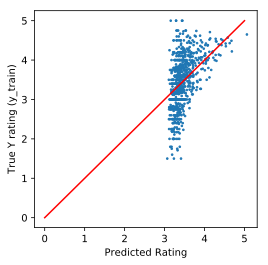

In [18]:
plt.figure(figsize=(4,4))
plt.scatter(poly_lasso.predict(X_train), y_train, s=3)
plt.xlabel("Predicted Rating")
plt.ylabel("True Y rating (y_train)")
plt.plot(range(6), c='r');

# Ridge Regression

In [279]:
#Straight Ridge Regression

#alphas = [1e-14,1e-10,1e-6,1e-3,1e-2,1e-1,1,100]
ridge = RidgeCV(cv=5)
ridge.fit(X_train, y_train)
print("intercept:",ridge.intercept_)
# print("coefficients,",ridge.coef_)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, ridge.predict(X_train))))
print("Train MSE:", metrics.mean_squared_error(y_train, ridge.predict(X_train)))
print("Train R^2:", ridge.score(X_train, y_train))
print("")

##### Save these for final model evaluation!
# print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# print("Test MSE:", metrics.mean_squared_error(y_test, y_pred))
# print('Test R^2: ', est.score(X_test, y_test))

print("")

#coefs_list = cont_feats + onehot_feats + list(mlb.classes_) + list(lb.classes_) ## Everything
# newlist = onehot_feats + list(mlb.classes_) + list(lb.classes_) ## remove continuous features
# newlist = cont_feats ## only continuous features
#pprint.pprint(sorted(zip(coefs_list, np.round(ridge.coef_,3)), key=lambda x: x[1], reverse=True))

intercept: 3.200796852917993
Train RMSE: 0.5963705394905316
Train MSE: 0.35565782037222776
Train R^2: 0.2253736141589826




In [27]:
"""Polynomial with RidgeCV"""

alphas = [1e-14,1e-10,1e-6,1e-3,1e-2,1e-1,1,100]
poly_ridge = make_pipeline(PolynomialFeatures(2, interaction_only=True), RidgeCV(cv=3, alphas=alphas))
poly_ridge.fit(X_train, y_train)
#print("intercept:",poly_ridge.intercept_)
# print("coefficients,",poly_ridge.coef_)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, poly_ridge.predict(X_train))))
print("Train MSE:", metrics.mean_squared_error(y_train, poly_ridge.predict(X_train)))
print("Train R^2:", poly_ridge.score(X_train, y_train))
print("")

##### Save these for final model evaluation!
print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, poly_ridge.predict(X_test))))
print("Test MSE:", metrics.mean_squared_error(y_test, poly_ridge.predict(X_test)))
print('Test R^2: ', poly_ridge.score(X_test, y_test))

print("")

#coefs_list = cont_feats + onehot_feats + list(mlb.classes_) + list(lb.classes_) ## Everything
# newlist = onehot_feats + list(mlb.classes_) + list(lb.classes_) ## remove continuous features
# newlist = cont_feats ## only continuous features
#pprint.pprint(sorted(zip(coefs_list, np.round(poly_ridge.coef_,3)), key=lambda x: x[1], reverse=True))

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:167: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:167: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:167: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:165: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.752179e-17
  overwrite_a=False)
/home/spe

Train RMSE: 18.752882926087707
Train MSE: 351.67061803955187
Train R^2: 0.4351040998909752

Test RMSE: 16.432925215141232
Test MSE: 270.04103112642446
Test R^2:  0.11842205106889026



/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [ ]:
# run lasso for feature selection, then put it through ridge

In [280]:
poly_ridge.get_params()['ridgecv'].alpha_

100.0

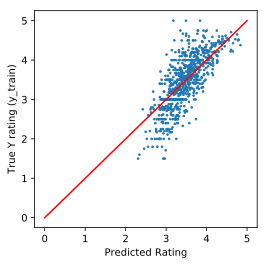

In [128]:
plt.figure(figsize=(4,4))
plt.scatter(poly_ridge.predict(X_train), y_train, s=3)
plt.xlabel("Predicted Rating")
plt.ylabel("True Y rating (y_train)")
plt.plot(range(6), c='r');

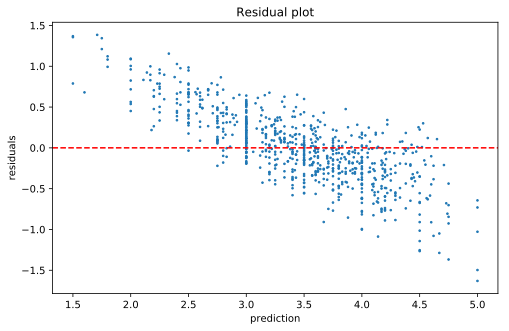

In [22]:
residual_plot(y_train, poly_ridge.predict(X_train))

# Feature Engineering and EDA

# Plots

In [ ]:
# try rating = log(votes), log(countreports)

In [ ]:
sns.pairplot(df_model, y_vars = 'rating', x_vars = df_special.columns[:-1]);

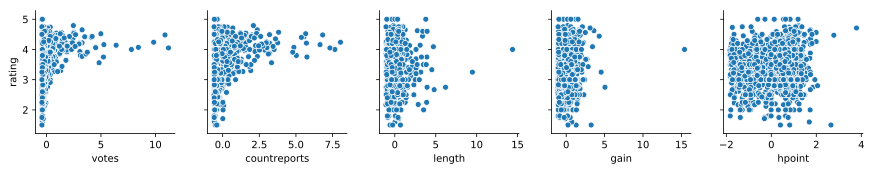

In [31]:
sns.pairplot(df_model, y_vars = 'rating', x_vars = cont_feats);

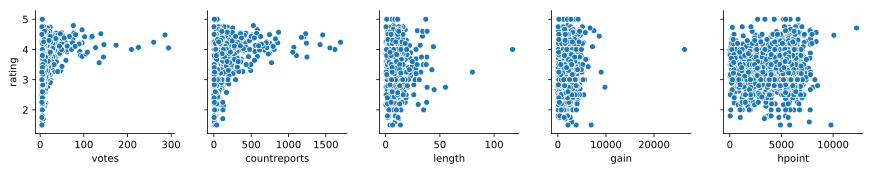

In [29]:
sns.pairplot(df, y_vars = 'rating', x_vars= cont_feats);

In [ ]:
# votes, count of tripreports, mountains, waterfall, summits, then hpoint, then ridges/passes

In [ ]:
# sns.pairplot(df[(df.votes > 3) & (df.length < 60) & (df.hpoint < 9000)],
#              x_vars=['votes','length','gain','hpoint','countreports'],
#              y_vars='rating')

In [ ]:
# # votes and count reports are highly correlated
# plt.scatter(df['votes'], df['countreports']);